### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 76998669

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

In [ ]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Load and process the dataset

In [ ]:
!wget https://github.com/GioBar00/AN2DL_23-24_Apple_Elixir_dataset/raw/main/public_data_clean.npz

# Load dataset
dataset = np.load('public_data_clean.npz', allow_pickle=True)


In [ ]:
def load_images_from_folder(folder):
    images = []

    # Iterate through files in the specified folder
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[...,::-1]

        # Make the image dataset squared
        dim = min(img.shape[:-1])
        img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2, (img.shape[1]-dim)//2:(img.shape[1]+dim)//2, :]

        # Resize the image to 224x224 pixels
        img = tfkl.Resizing(224, 224)(img)

        if img is not None:
            images.append(img)

    return np.array(images)

# Load images from the 'animals/' folder
animals_path = 'animals/'
animals = load_images_from_folder(animals_path)

# Load images from the 'items/' folder
items_path = 'items/'
items = load_images_from_folder(items_path)

In [ ]:
# Number of images to display
num_img = 10

# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(items[i], 0, 255))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()

# Create subplots for displaying animals
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(animals[i], 0, 255))  # Display clipped animal images
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Concatenate 'animals' and 'items' arrays along axis 0
X = np.concatenate([animals, items], axis=0)

# Create labels: 1 for 'animals', 0 for 'items'
y = np.concatenate([np.ones(len(animals)), np.zeros(len(items))], axis=0)

# Convert labels to one-hot encoding format
y = tfk.utils.to_categorical(y,2)

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=60, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=60, stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

### Train MobileNetV2 from scratch

In [ ]:
# Create MobileNetV2 model with specified settings
mobile = tfk.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights=None,
    pooling='avg',
)

# Display the model architecture with input shapes
tfk.utils.plot_model(mobile, show_shapes=True)

In [ ]:
# Create an input layer with shape (224, 224, 3)
inputs = tfk.Input(shape=(224, 224, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
model.summary()

In [ ]:
# Train the model
history = model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

In [ ]:
# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## Transfer Learning
Leveraging pre-trained network for a different classification problem
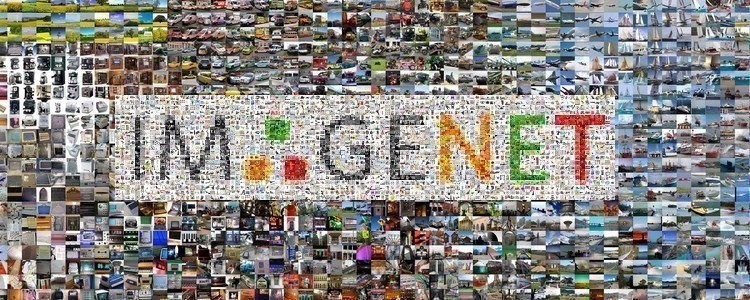

In [ ]:
mobile = tfk.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(mobile, show_shapes=True)

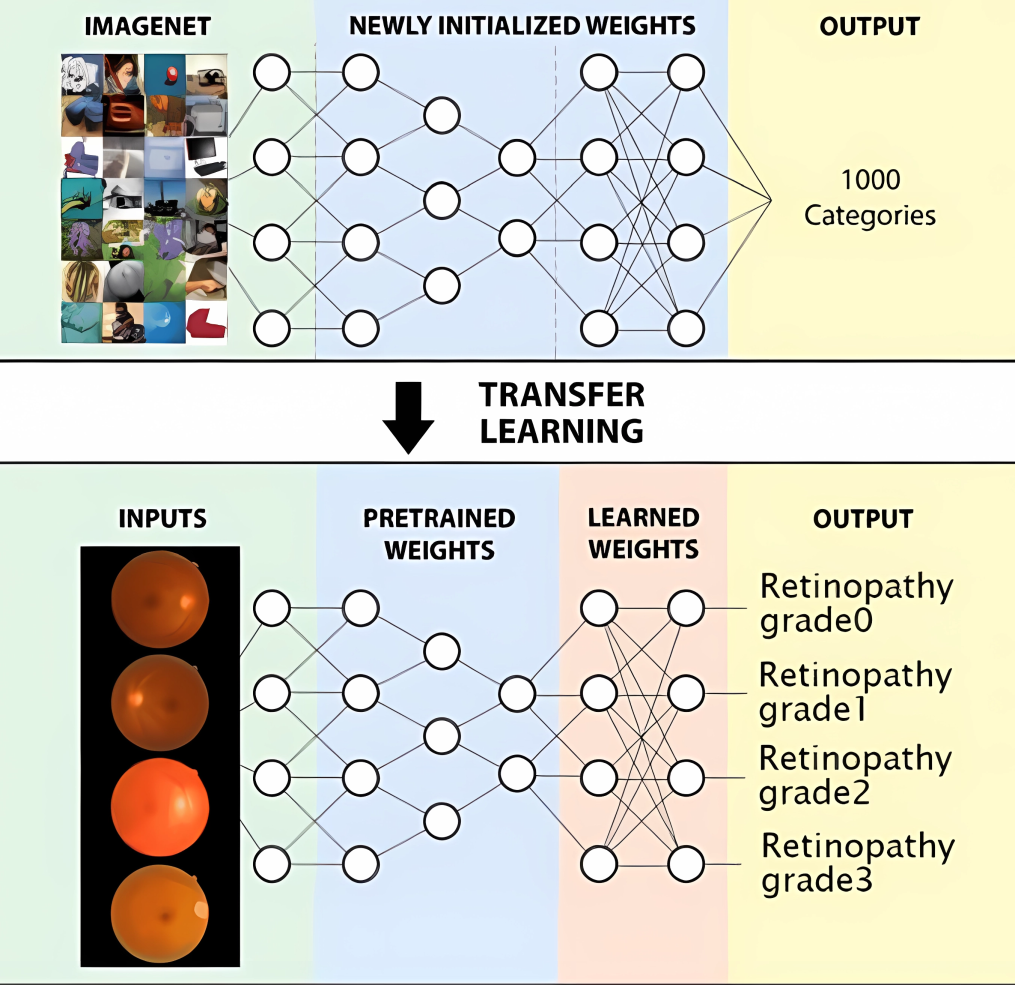

In [ ]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False

# Create an input layer with shape (224, 224, 3)
inputs = tfk.Input(shape=(224, 224, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

In [ ]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

In [ ]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the best model
tl_model.save('TransferLearningModel')
del tl_model

## Fine Tuning
Training also the backbone network. To this purpose it is better to
1.   Perform transfer learning, namely train the new classification head only
2.   Unfreeze the backbone layers (or possibly a few of them depending on the amount of training data) and train the entire netrwork. Note that the classification head needs to be a properly trained model.



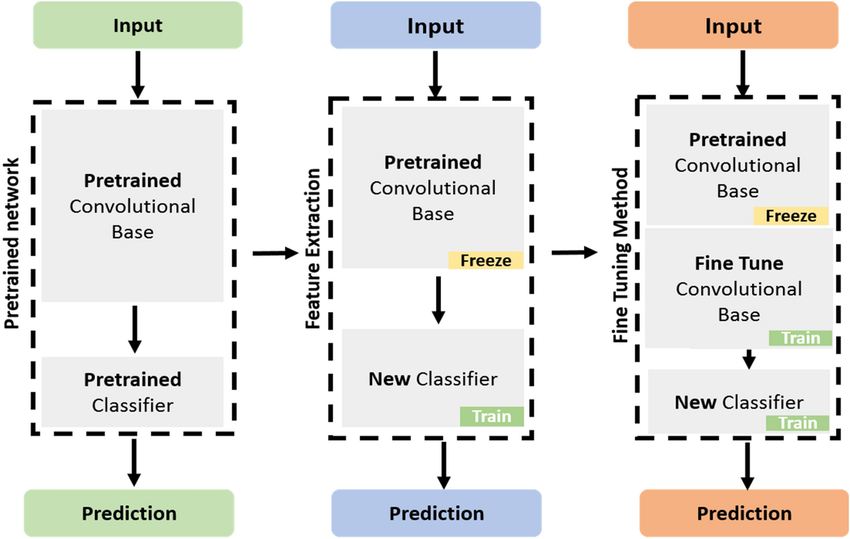

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel')
ft_model.summary()

In [ ]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('mobilenetv2_1.00_224').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_224').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Freeze first N layers, e.g., until the 133rd one
N = 133
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_224').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_224').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
# Save the best model
ft_model.save('FineTuningModel')
del ft_model

### Test on your own data

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('FineTuningModel')
ft_model.summary()

In [ ]:
test_path = 'test_images/'
test = load_images_from_folder(test_path)
test.shape

In [ ]:
# predict the test image
test_predictions = ft_model.predict(preprocess_input(test*255), verbose=0)

index = 3
prediction = test_predictions[index]

if prediction[0] >= prediction[1]:
    label = 'item'
    probability = float("{:.{}f}".format(prediction[0], 4))*100

else:
    label = 'animal'
    probability = float("{:.{}f}".format(prediction[1], 4))*100

plt.title(f'{label} ({probability}%)')
plt.imshow(np.squeeze(test[index]))
plt.show()

### TODO Exercise
Practice the various transformations, create your own successful preprocessing pipeline and compare different Keras applications' architectures.

What happens if you combine augmentation techniques with fine tuning?

*Credits: Eugenio Lomurno, 📧 eugenio.lomurno@polimi.it*